# Artificial pyramidal cells on a linear track

This script is a simulation of a mouse running in a linear track (100 mm) and the response of pyramidal cells in the hippocampus. The place field of each pyramidal cell is described by a Gaussian distribution. To sample the spikes from each cell as the mouse runs in the linear track, Poisson distributions are sample using as the rate the sample from the place field, i.e., the Gaussian distribution.

First, include the libraries:

In [7]:
from numpy import *
from scipy.stats import multivariate_normal, poisson
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline 

Define the place fields of each cell using Gaussian distributions. The parameters are the variance () and the center of the place field

In [2]:
def place_field(pos, variance, firing_rate=0.2, baseline=0.001):
    """
    Creates a 1D Gaussian place field with center pos and
    covariance matrix. The max is scaled to desired firing_rate.
    Baseline gives the baseline firing rate.

    :return pdf: Probability density function
    """
    mv = multivariate_normal(pos, variance)
    scale_constant = mv.pdf(pos)

    def pdf(arena):
        fr = firing_rate * mv.pdf(arena) / scale_constant + baseline
        return fr
    return pdf

Initialize the linear tack with dimensions length = 100 mm. Define the number of place fields to be randombly allocated in the track (n_fields), the variance of the place field is randomly set from a Gassian distribution with median 20 mm, and std 8 mm. 

In [ ]:
def setup(n_fields=100):
    """
    Setup a linear track with dimmensions 1 x 100 mm
    :param n_objects: number of place fields
    """
    xmax = 100
    pfields = list()
    centers = list()
    for f in range(n_fields):
        origin = random.normal(xmax / 2, xmax / 2)
        variance = random.normal(loc=20., scale=8., size=1)
        pfields.append(place_field(origin, variance))
        centers.append(origin)

    return pfields, centers

Compute firing rate for each neuron given place field pdf by sampling a Poisson distribution.

In [3]:
def simulate_spikes(tuning_curve, rx):
    """
    Compute firing rate for each neuron given place field center
    and sample number of observed spikes in one time unit

    :param tuning_curve: pdf of the tuning curve for each cell
    :param rx: position of the rat in the linear track
    :return rates, obs_spikes : firing rate as the rate of the Poisson distribution and spikes sampled from the pdf
    """
    rates = []
    obs_spikes = []
    for n, pfield in enumerate(tuning_curve):
        rate = pfield(rx)
        spikes = poisson.rvs(rate)
        rates.append(rate)
        obs_spikes.append(spikes)
    return rates, obs_spikes

Define other utilitarian functions to make things easier, including rater plot, and saving

In [4]:
def sample(pos, time, p_fields, fig=None, **kwargs):
    ax2 = None
    if fig:
        ax2 = update_figure(fig, **kwargs)

    all_spikes = list()
    for p, t in zip(pos, time):
        rates, obs_spikes = simulate_spikes(p_fields, p)
        for c, spks in enumerate(obs_spikes):
            if spks != 0:
                times = linspace(t, t + 0.001, spks)
                cell = ones(spks) * c
                if fig:
                    ax2.plot(times, ones(spks) * c, '|', color='r')
                all_spikes.extend(column_stack((times, cell)))

    return ax2, all_spikes

def update_figure(fig, **kwargs):
    """updates the subplots in a figure and shares the x axis"""

    n = len(fig.axes)
    for i in range(n):
        fig.axes[i].change_geometry(n + 1, 1, i + 1)
    if 'link' in kwargs:
        link_to = kwargs['link']
        ax = fig.add_subplot(n + 1, 1, n + 1, sharex=fig.axes[link_to])
    else:
        ax = fig.add_subplot(n + 1, 1, n + 1)


    return ax

def save_spks(spikes, name):
    savetxt(name, spikes, '%3.5f\t%3d')

## Simulation

Define the parameters for the simulation including: number of cells (n_cells), the speed of the animal in the track (constant) in cm / s (speed), the distance that the animal run (max_pos = [0-100]), and the folder where the spike trains will be save in txt format.

In [14]:
basepath = '/media/bigdata/synthetic/'  # folder where you want to save the txt file
show = True  # show the place fields, position of the animal, and rater of spikes
n_cells = 50  # number of cells
speed = 5.  # cm/s
max_pos = 80  # maximum position of the animal
t_taken = max_pos / (speed * 10) 
Fs = 1000  # sampling frequency

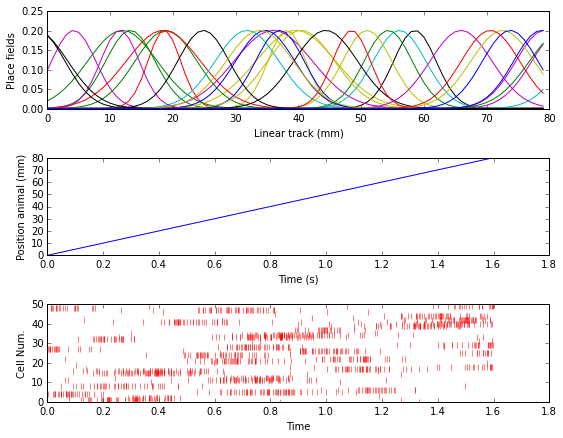

In [15]:
time = linspace(0, t_taken, int(t_taken * Fs))
pos_rat = linspace(0, max_pos, int(t_taken * Fs))
p_fields, centers = setup(n_cells)
# Show place fields distribution
if show:
    fig = plt.figure(frameon=False, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    plt.subplots_adjust(hspace=0.5)

for p in p_fields:
    ax.plot(p(range(0, max_pos)))
plt.ylabel('Place fields')
plt.xlabel('Linear track (mm)')

ax1 = update_figure(fig)
ax1.plot(time, pos_rat)
plt.ylabel('Position animal (mm)')
plt.xlabel('Time (s)')
ax2, spikes = sample(pos_rat, time, p_fields, fig, link=1)
plt.ylabel('Cell Num.')
plt.xlabel('Time')

key = 'spikes_{}_{}.'.format(n_cells, dt.date.today())
fig.savefig(basepath + key + 'png')
save_spks(spikes, basepath + key + 'txt')
plt.show()